In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections
from tqdm.auto import tqdm
import scipy.sparse as sp
import pickle as pkl
import os

In [2]:
import time
import argparse
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from math import ceil

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from utils import load_file, preprocessing, get_vocab, load_embeddings, create_gows, accuracy, generate_batches, AverageMeter
from models import MPAD

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import tqdm.auto as tqdm

[nltk_data] Downloading package stopwords to /home/sc/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
import networkx as nx
import seaborn as sns
sns.set_style('ticks')
%matplotlib inline

In [7]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [8]:
def create_gows(docs, vocab, window_size, directed, to_normalize, use_master_node):
    adj = list()
    features = list()
    idx2term = list()

    for doc in tqdm.tqdm(docs):
        edges = dict()

        idx = dict()
        l_terms = list()
        for i in range(len(doc)):
            if doc[i] not in idx:
                l_terms.append(doc[i])
                idx[doc[i]] = len(idx)
        idx2term.append(l_terms)
        if use_master_node:
            idx["master_node"] = len(idx)
        X = np.zeros(len(idx), dtype=np.int32)
        for w in idx:
            if w != "master_node":
                X[idx[w]] = vocab[w]
            else:
                X[idx[w]] = len(vocab)
        for i in range(len(doc)):
            for j in range(i + 1, i + window_size):
                if j < len(doc):
                    if (doc[i], doc[j]) in edges:
                        edges[(doc[i], doc[j])] += 1.0 / (j - i)
                        if not directed:
                            edges[(doc[j], doc[i])] += 1.0 / (j - i)
                    else:
                        edges[(doc[i], doc[j])] = 1.0 / (j - i)
                        if not directed:
                            edges[(doc[j], doc[i])] = 1.0 / (j - i)
            if use_master_node:
                edges[(doc[i], "master_node")] = 1.0
                edges[("master_node", doc[i])] = 1.0

        edge_s = list()
        edge_t = list()
        val = list()
        for edge in edges:
            edge_s.append(idx[edge[0]])
            edge_t.append(idx[edge[1]])
            val.append(edges[edge])
        A = sp.csr_matrix((val, (edge_s, edge_t)), shape=(len(idx), len(idx)))
        if len(edges) == 0:
            A = sp.csr_matrix(([0], ([0], [0])), shape=(1, 1))
            X = np.zeros(1, dtype=np.int32)

        if directed:
            A = A.transpose()
        if to_normalize and A.size > 1:
            A = normalize(A)
        adj.append(A)
        features.append(X)

    return adj, features, idx2term


In [9]:
def create_gows(docs, vocab, window_size, directed, to_normalize, use_master_node):
    adj = list()
    features = list()
    idx2term = list()
    
    for enum, doc in tqdm.tqdm(enumerate(docs)):
        try:
            edges = dict()

            idx = dict()
            l_terms = list()
            for i in range(len(doc)):
                if doc[i] not in idx:
                    l_terms.append(doc[i])
                    idx[doc[i]] = len(idx)
            idx2term.append(l_terms)
            if use_master_node:
                idx["master_node"] = len(idx)
            X = np.zeros(len(idx), dtype=np.int32)
            for w in idx:
                if w != "master_node":
                    X[idx[w]] = vocab[w]
                else:
                    X[idx[w]] = len(vocab)
            for i in range(len(doc)):
                for j in range(i + 1, i + window_size):
                    if j < len(doc):
                        if (doc[i], doc[j]) in edges:
                            edges[(doc[i], doc[j])] += 1.0 / (j - i)
                            if not directed:
                                edges[(doc[j], doc[i])] += 1.0 / (j - i)
                        else:
                            edges[(doc[i], doc[j])] = 1.0 / (j - i)
                            if not directed:
                                edges[(doc[j], doc[i])] = 1.0 / (j - i)
                if use_master_node:
                    edges[(doc[i], "master_node")] = 1.0
                    edges[("master_node", doc[i])] = 1.0

            edge_s = list()
            edge_t = list()
            val = list()
            for edge in edges:
                edge_s.append(idx[edge[0]])
                edge_t.append(idx[edge[1]])
                val.append(edges[edge])
            A = sp.csr_matrix((val, (edge_s, edge_t)), shape=(len(idx), len(idx)))
            if len(edges) == 0:
                A = sp.csr_matrix(([0], ([0], [0])), shape=(1, 1))
                X = np.zeros(1, dtype=np.int32)

            if directed:
                A = A.transpose()
            if to_normalize and A.size > 1:
                A = normalize(A)
            adj.append(A)
            features.append(X)
        except:
            print("skipping: ",enum)
            docs.pop(enum)
    return adj, features, idx2term, docs


### Make Graph

In [10]:
args = {}
args['path_to_dataset'] = '../datasets/subjectivity.txt'
args['path_to_embeddings'] = "../GoogleNews-vectors-negative300.bin"
args['no_cuda'] = False
args['epochs'] = 200
args['lr'] = 0.001
args['hidden'] = 64
args['penultimate'] = 64
args['message_passing_layers']=2
args['window_size'] = 2
args['directed'] = True
args['use_master_node'] = True
args['normalize'] = True
args['dropout'] = 0.5
args['batch_size'] = 128
args['patience'] = 20
args = dotdict(args)

In [11]:
# Read data
docs, class_labels = load_file("../datasets/subjectivity/unique/0.txt")
docs = preprocessing(docs)

enc = LabelEncoder()
class_labels = enc.fit_transform(class_labels)

nclass = np.unique(class_labels).size
y = list()
for i in range(len(class_labels)):
    t = np.zeros(1)
    t[0] = class_labels[i]
    y.append(t)

In [12]:
vocab = get_vocab(docs)
embeddings = load_embeddings("../GoogleNews-vectors-negative300.bin", vocab)

Vocabulary size:  24123
Existing vectors: 20141


In [13]:
# random sentecnce with lot of stop words
cleaned_docs = []
for d in docs:
    sample_text = " ".join(d)
    text_tokens = word_tokenize(sample_text)

    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
    cleaned_docs.append(tokens_without_sw)

In [14]:
USE_MASTER_NODE = False
NORMALIZE = False
adj, features, _, _  = create_gows(docs, vocab, 4, args.directed, NORMALIZE, USE_MASTER_NODE)
adj = [a.todense() for a in adj]
graphs = [nx.from_numpy_array(a) for a in adj]

Text(0.5, 1.0, 'Maximum Degree (Uncleaned)')

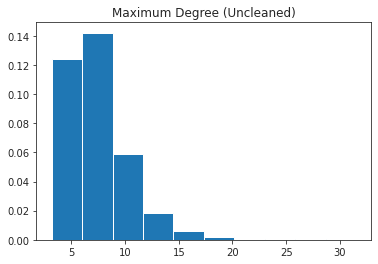

In [15]:
counts = np.zeros(len(adj))
for e_num, G in enumerate(graphs):
    degree_sequence = sorted([d for n, d in G.degree(weight='weight')], reverse=True)
    dmax = max(degree_sequence)
    counts[e_num] = dmax
plt.hist(counts,density=True,bins=10)
plt.title("Maximum Degree (Uncleaned)")

In [16]:
len(cleaned_docs)

9995

In [17]:
USE_MASTER_NODE = False
NORMALIZE = False
cleaned_adj, cleaned_features, _, cleaned_docs = create_gows(cleaned_docs, vocab, 2, args.directed, NORMALIZE, USE_MASTER_NODE)
cleaned_adj = [a.todense() for a in cleaned_adj]
cleaned_graphs = [nx.from_numpy_array(a) for a in cleaned_adj]

skipping:  6
skipping:  7
skipping:  14
skipping:  28
skipping:  34
skipping:  37
skipping:  42
skipping:  44
skipping:  49
skipping:  53
skipping:  56
skipping:  62
skipping:  68
skipping:  71
skipping:  78
skipping:  86
skipping:  94
skipping:  96
skipping:  112
skipping:  123
skipping:  127
skipping:  128
skipping:  171
skipping:  177
skipping:  183
skipping:  186
skipping:  187
skipping:  208
skipping:  213
skipping:  217
skipping:  227
skipping:  230
skipping:  238
skipping:  251
skipping:  253
skipping:  259
skipping:  265
skipping:  274
skipping:  287
skipping:  288
skipping:  292
skipping:  293
skipping:  306
skipping:  316
skipping:  323
skipping:  325
skipping:  326
skipping:  328
skipping:  331
skipping:  332
skipping:  337
skipping:  343
skipping:  355
skipping:  359
skipping:  364
skipping:  378
skipping:  382
skipping:  391
skipping:  396
skipping:  408
skipping:  413
skipping:  422
skipping:  423
skipping:  428
skipping:  435
skipping:  447
skipping:  461
skipping:  480


skipping:  3995
skipping:  4002
skipping:  4023
skipping:  4027
skipping:  4029
skipping:  4038
skipping:  4076
skipping:  4090
skipping:  4095
skipping:  4100
skipping:  4110
skipping:  4111
skipping:  4115
skipping:  4119
skipping:  4135
skipping:  4144
skipping:  4146
skipping:  4153
skipping:  4161
skipping:  4175
skipping:  4180
skipping:  4188
skipping:  4190
skipping:  4198
skipping:  4209
skipping:  4217
skipping:  4220
skipping:  4227
skipping:  4232
skipping:  4244
skipping:  4245
skipping:  4248
skipping:  4251
skipping:  4259
skipping:  4260
skipping:  4266
skipping:  4271
skipping:  4281
skipping:  4292
skipping:  4296
skipping:  4298
skipping:  4302
skipping:  4308
skipping:  4317
skipping:  4326
skipping:  4333
skipping:  4335
skipping:  4341
skipping:  4345
skipping:  4347
skipping:  4357
skipping:  4363
skipping:  4369
skipping:  4380
skipping:  4382
skipping:  4392
skipping:  4406
skipping:  4412
skipping:  4453
skipping:  4462
skipping:  4472
skipping:  4482
skipping

Text(0.5, 1.0, 'Maximum Degree (Cleaned)')

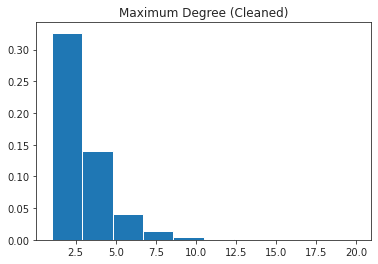

In [18]:
cleaned_counts = np.zeros(len(cleaned_adj))
for e_num, G in enumerate(cleaned_graphs):
    degree_sequence = sorted([d for n, d in G.degree(weight='weight')], reverse=True)
    dmax = max(degree_sequence)
    cleaned_counts[e_num] = dmax
plt.hist(cleaned_counts,density=True)
plt.title("Maximum Degree (Cleaned)")

In [20]:
idx = 0
print("Doc {}: {}".format(idx," ".join(docs[idx])))
print("Cleaned Doc {}: {}".format(idx," ".join(cleaned_docs[idx])))

Doc 0: styled after vh1s behind the music , this mockumentary associate in nursing profiles the rise and fall of an internet startup , call off called icevan com
Cleaned Doc 0: styled vh1s behind music , mockumentary associate nursing profiles rise fall internet startup , call called icevan com


Doc 8526: this isnt an original film , it is an effective one but
Cleaned Doc 8526: soundtrack alone actual heart rate affair rock fanny


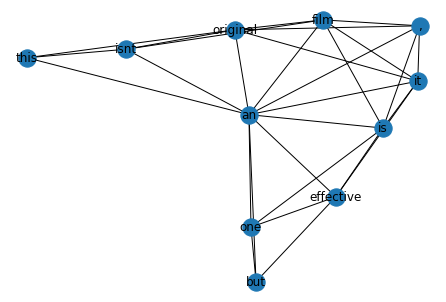

In [22]:
idx = np.random.randint(0,len(adj))
print("Doc {}: {}".format(idx," ".join(docs[idx])))
print("Cleaned Doc {}: {}".format(idx," ".join(cleaned_docs[idx])))
node_names = list(dict.fromkeys(docs[idx])) #need to do this to preserve ordering!
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(graphs[idx],labels=label_dict)

Doc 4553: loonies is old touching comedy about a psychiatric patients who are forced to exchange their familiar surroundings for an five fashioned , impersonal institution
Cleaned Doc 4553: like coming long running , comfortably written television serial publication youve lose first half dozen episodes probably habit construe adjacent six


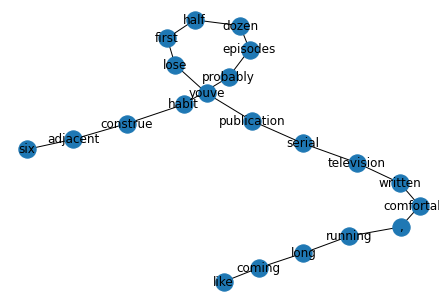

In [276]:
print("Doc {}: {}".format(idx," ".join(docs[idx])))
print("Cleaned Doc {}: {}".format(idx," ".join(cleaned_docs[idx])))
node_names = list(dict.fromkeys(cleaned_docs[idx])) #need to do this to preserve ordering!
if USE_MASTER_NODE:
    label_dict = {i+1:v for i,v in enumerate(node_names)}
    label_dict[0] = "MN"
else:
    label_dict = {i:v for i,v in enumerate(node_names)}
nx.draw(cleaned_graphs[idx],labels=label_dict)